In [1]:
from tqdm import tqdm
import os
import time
from datetime import datetime
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

import re
import warnings


warnings.simplefilter("ignore")


In [2]:
from utils.Meter import dice_coef_metric_per_classes, jaccard_coef_metric_per_classes

from utils.BratsDataset import BratsDataset

from utils.Meter import BCEDiceLoss

from models.UNet3d import UNet3d
from models.UNet3dSingleConv import UNet3dSingleConv
from models.UNet3dDropout import UNet3dDropout
from models.SwinUNETR import SwinUNETR
from models.UNet3d_SELU import UNet3d_SELU
from models.UNet3d_atten import UNet3d_atten
from models.ONet3d import ONet3d
from models.ONet3d_v2 import ONet3d_v2
from models.ONet3d_v3 import ONet3d_v3
from models.ONet3d_v3_DoubleConv import ONet3d_v3_DoubleConv
from models.UNet3d_GELU import UNet3d_GELU
from models.ONet3d_v3_GELU import ONet3d_v3_GELU
from models.SphereNet3d import SphereNet3d


### `get_dataloaders` returns the train, val and test dataloader; used to generate the test dataloader for evaluation

In [3]:
def get_dataloaders(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    # phase: str,
    val_fold: int = 0,  # Choose which fold to be the validation fold
    test_fold: int = 1,
    batch_size: int = 1,
    num_workers: int = 4,
    do_resizing: bool = True,
):
    assert (val_fold != test_fold)

    df = pd.read_csv(path_to_csv)

    '''Returns: dataloader for the model training'''
    # Data in folds other than 0 are used for training
    train_df = df.loc[~df['fold'].isin(
        [val_fold, test_fold])].reset_index(drop=True)
    # Data in fold 0 is used for validation
    val_df = df.loc[df['fold'] == val_fold].reset_index(drop=True)
    test_df = df.loc[df['fold'] == test_fold].reset_index(drop=True)

    # dataset = dataset(df, phase)
    train_dataset = dataset(train_df, "train", do_resizing=do_resizing)
    val_dataset = dataset(val_df, "val", do_resizing=do_resizing)
    test_dataset = dataset(test_df, "test", do_resizing=do_resizing)
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return train_dataloader, val_dataloader, test_dataloader


## Create a dictionary which maps the model names/directories in the Logs folder to their respective model initialisations.

In [4]:
modelDict = {
    "3DOnet_DoubleConv_Kernel1": ONet3d_v3_DoubleConv(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1": ONet3d_v3(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1_32_Channels": ONet3d_v3(in_channels=4, n_classes=3, n_channels=32).to('cuda'),
    "3DOnet_SingleConv_Kernel1_GELU": ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel1_GELU_AdamW": ONet3d_v3_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel3": ONet3d_v2(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DOnet_SingleConv_Kernel5": ONet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet": UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_32_Channels": UNet3d(in_channels=4, n_classes=3, n_channels=32).to('cuda'),
    "3DUnet_Atten": UNet3d_atten(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_Dropout": UNet3dDropout(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_GELU": UNet3d_GELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_SELU": UNet3d_SELU(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "3DUnet_SingleConv": UNet3dSingleConv(in_channels=4, n_classes=3, n_channels=24).to('cuda'),
    "SphereNet3D": SphereNet3d(in_channels=4, n_classes=3, n_channels=16).to('cuda'),
    "SwinUNETR": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2, 4, 8, 16)).to('cuda'),
    "SwinUNETR_AdamW": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(1, 1, 1, 1), num_heads=(2, 4, 8, 16)).to('cuda'),
    "SwinUNETR_DoubleLayerDepth": SwinUNETR(in_channels=4, out_channels=3, img_size=(128, 224, 224), depths=(2, 2, 2, 2), num_heads=(2, 4, 8, 16)).to('cuda'),
  }

### Define function used for evaluating a model over all classes

In [5]:
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    ids = {"Ids":list()}

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            imgs, targets = data['image'], data['mask']
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)
            ids["Ids"].extend(data["Id"])

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])
    return dice_scores_per_classes, iou_scores_per_classes, ids


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


### Evaluates all models
### While doing so, saves evaluated scores on every sample in test set into respective models' Log folders; uses best checkpoint
### Returns dictionary of results

In [6]:

  
def evaluate_all(chkpt_type="best", results_dict = {}):
  chkpt_prefix = "your_best_model" if chkpt_type == "best" else "your_last_epoch_model"
  for dirname in os.listdir("Logs"):
    start = datetime.now()
    model_name = dirname
    model = modelDict[model_name]
    results_dict[model_name] = {}
    
    checkpoint_path = None
    
    for filename in os.listdir(f"Logs/{dirname}"):
      if chkpt_prefix in filename:
        checkpoint_path = f"Logs/{dirname}/{filename}"
        break
    
    try:
      model.load_state_dict(torch.load(
          checkpoint_path, map_location='cpu'))
      model.eval()
      print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    except Exception as e:
      print(f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
      print(e)
      
    _, _, test_dataloader = get_dataloaders(
        dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)
    
    dice_scores_per_classes, iou_scores_per_classes, ids = compute_scores_per_classes(
        model, test_dataloader, ['WT', 'TC', 'ET']
    )
    ids_df = pd.DataFrame(ids)
    ids_df.columns = ['Ids']
    
    dice_df = pd.DataFrame(dice_scores_per_classes)


    dice_df.columns = ['WT dice', 'TC dice', 'ET dice']

    iou_df = pd.DataFrame(iou_scores_per_classes)
    iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard']
    val_metics_df = pd.concat([ids_df, dice_df, iou_df], axis=1, sort=True)
    val_metics_df = val_metics_df.loc[:, ['Ids',
                                          'WT dice', 'WT jaccard',
                                          'TC dice', 'TC jaccard',
                                          'ET dice', 'ET jaccard']]
    mean_metrics_df = val_metics_df.mean()
    val_metics_df.sort_values(by=["Ids"], inplace=True)
    val_metics_df = val_metics_df.reset_index(drop=True)
    # results_dict[model_name]["val_metics_df"] = val_metics_df
    val_metics_df.to_csv(f"Logs/{model_name}/eval_results.csv")
    print(f"Saved individual results on test set to Logs/{model_name}/eval_results.csv")
    results_dict[model_name]["WT dice"] = mean_metrics_df["WT dice"]
    results_dict[model_name]["WT jaccard"] = mean_metrics_df["WT jaccard"]
    results_dict[model_name]["TC dice"] = mean_metrics_df["TC dice"]
    results_dict[model_name]["TC jaccard"] = mean_metrics_df["TC jaccard"]
    results_dict[model_name]["ET dice"] = mean_metrics_df["ET dice"]
    results_dict[model_name]["ET jaccard"] = mean_metrics_df["ET jaccard"]
    inference_time = datetime.now() - start
    results_dict[model_name]["Inference time"] = inference_time
    
    del model
  return results_dict





### Save dictionary of results

In [8]:
eval_dict_best_epoch = evaluate_all(chkpt_type="best")


3DOnet_SingleConv_Kernel1_32_Channels loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_32_Channels/your_best_model_20230314-193438.pth. parameters: 5597571
Saved individual results on test set to Logs/3DOnet_SingleConv_Kernel1_32_Channels/eval_results.csv
SphereNet3D loaded with chkpt: Logs/SphereNet3D/your_best_model_20230318-234612.pth. parameters: 6134019
Saved individual results on test set to Logs/SphereNet3D/eval_results.csv
3DUnet_SingleConv loaded with chkpt: Logs/3DUnet_SingleConv/your_best_model_20230322-164448.pth. parameters: 3006507
Saved individual results on test set to Logs/3DUnet_SingleConv/eval_results.csv
3DOnet_SingleConv_Kernel1_GELU_AdamW loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/your_best_model_20230317-181323.pth. parameters: 3150435
Saved individual results on test set to Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/eval_results.csv
SwinUNETR_AdamW loaded with chkpt: Logs/SwinUNETR_AdamW/your_best_model_20230311-061544.pth. parameters: 14981601

### Saves dictionary of results as JSON in results folder

In [31]:
import json
with open("results/eval_best_epoch.json", "w") as outfile:
    json.dump(eval_dict_best_epoch, outfile,
              indent=4, sort_keys=True, default=str)


### Every folder (model name) in `Logs` contain a `trainer_properties.txt` file which contains tracked statistics across all 50 train epochs

### The following two cells retrieves these tracked statistics across all models in `Logs` and saves them in `train_results_dict`

In [15]:
from utils.viz_eval_utils import get_losses, get_param_count, get_dice_scores, get_jaccard_scores, get_train_run_time


FILENAME = "Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt"

get_param_count(FILENAME)
get_train_run_time(FILENAME)
get_losses(FILENAME)
get_dice_scores(FILENAME)
get_jaccard_scores(FILENAME)
print("Test done")


Parameter count = 5896515 in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
Trainer runtime = 05:51:38.640594 in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val losses found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val dice score found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/3DOnet_DoubleConv_Kernel1/trainer_properties.txt
Test done


In [16]:
train_results_dict = {}

for dirname in os.listdir("Logs"):
  model_name = dirname
  train_results_dict[model_name] = {}

  filename = f"Logs/{dirname}/trainer_properties.txt"
  parameter_count = get_param_count(filename)
  trainer_runtime = get_train_run_time(filename)
  train_losses, val_losses = get_losses(filename)
  train_dices, val_dices = get_dice_scores(filename)
  train_jaccards, val_jacards = get_jaccard_scores(filename)
  train_results_dict[model_name]["parameter_count"] = parameter_count
  train_results_dict[model_name]["trainer_runtime"] = trainer_runtime
  train_results_dict[model_name]["train_losses"] = train_losses
  train_results_dict[model_name]["val_losses"] = val_losses
  train_results_dict[model_name]["train_dices"] = train_dices
  train_results_dict[model_name]["val_dices"] = val_dices
  train_results_dict[model_name]["train_jaccards"] = train_jaccards
  train_results_dict[model_name]["val_jacards"] = val_jacards


Parameter count = 5597571 in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
Trainer runtime = 12:10:09.814454 in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val losses found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val dice score found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/3DOnet_SingleConv_Kernel1_32_Channels/trainer_properties.txt
Parameter count = 6134019 in Logs/SphereNet3D/trainer_properties.txt
Trainer runtime = 10:27:29.978756 in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val losses found in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val dice score found in Logs/SphereNet3D/trainer_properties.txt
50 train and 50 val jaccard score found in Logs/SphereNet3D/trainer_properties.txt
Parameter count = 3006507 in Logs/3DUnet_SingleConv/trainer_properties.txt
Trainer runtime = 05:34:3

## Obtain color palette with shades corresponding to parameter counts

### We have 4 broad families of model architecture: UNET, SwinUNETR, ONET (Our own) and SphereNET (Our own)

### We obtain the color palettes for better visualisation, with different colours corresponding to different model family and darker shades (in general) representing greater parameter count

### UNET corresponds to blue, ONET to purple, SphereNET to orange and SwinUNETR to green

In [17]:
# obtain color palette with shades corresponding to parameter counts

Unet_colors = ["#D8E8FA", "#CCE0F5", "#B2D2F7",
               "#91C2FA", "#69ADF9", "#3E97FA", "#117FFB"]  # blue
# Onet_colors = ["#F9E0ED", "#F9C7E1", "#F9A5D1", "#FB7CBE", "#FC57AC", "#FA2693", "#DE0977"] # pink
Onet_colors = ["#F4E6F7", "#F0CCF9", "#EBABF9",
               "#E483FA", "#DC4AFC", "#CF0CFA", "#9703B8"]  # purple
Swin_colors = ["#D3F3C4", "#A3F47D", "#44C10A"]  # green
spherenet_colors = ["#FC9A03"]  # orange
Unet_dict = {}
Onet_dict = {}
Swin_dict = {}
spherenet_dict = {}
for model_name in train_results_dict:
    if "Unet" in model_name:
        Unet_dict[model_name] = train_results_dict[model_name]["parameter_count"]
    elif "Onet" in model_name:
        Onet_dict[model_name] = train_results_dict[model_name]["parameter_count"]
    elif "Swin" in model_name:
        Swin_dict[model_name] = train_results_dict[model_name]["parameter_count"]
    else:
        spherenet_dict[model_name] = train_results_dict[model_name]["parameter_count"]

sorted_Unet_models = sorted(Unet_dict.items(), key=lambda x: x[1])
sorted_Onet_models = sorted(Onet_dict.items(), key=lambda x: x[1])
sorted_Swin_models = sorted(Swin_dict.items(), key=lambda x: x[1])
sorted_spherenet_models = sorted(spherenet_dict.items(), key=lambda x: x[1])

cols = {}
for i in range(len(sorted_Unet_models)):
    cols[sorted_Unet_models[i][0]] = Unet_colors[i]
for i in range(len(sorted_Onet_models)):
    cols[sorted_Onet_models[i][0]] = Onet_colors[i]
for i in range(len(sorted_Swin_models)):
    cols[sorted_Swin_models[i][0]] = Swin_colors[i]
for i in range(len(sorted_spherenet_models)):
    cols[sorted_spherenet_models[i][0]] = spherenet_colors[i]


## Plot parameter count and trainer runtime for each model

### Plots are saved in the `results` folder

### Results suggest that 3DUNET (baseline, blue) is always quicker to train compared to other models despite potentially having a greater parameter count than some 3DONET (ours, purple) models

### *Trainer runtime may be unreliable and is subject to potentially large run-to-run variance due to the varying conditions of the running device. 

2023-03-26 21:44:09,683 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


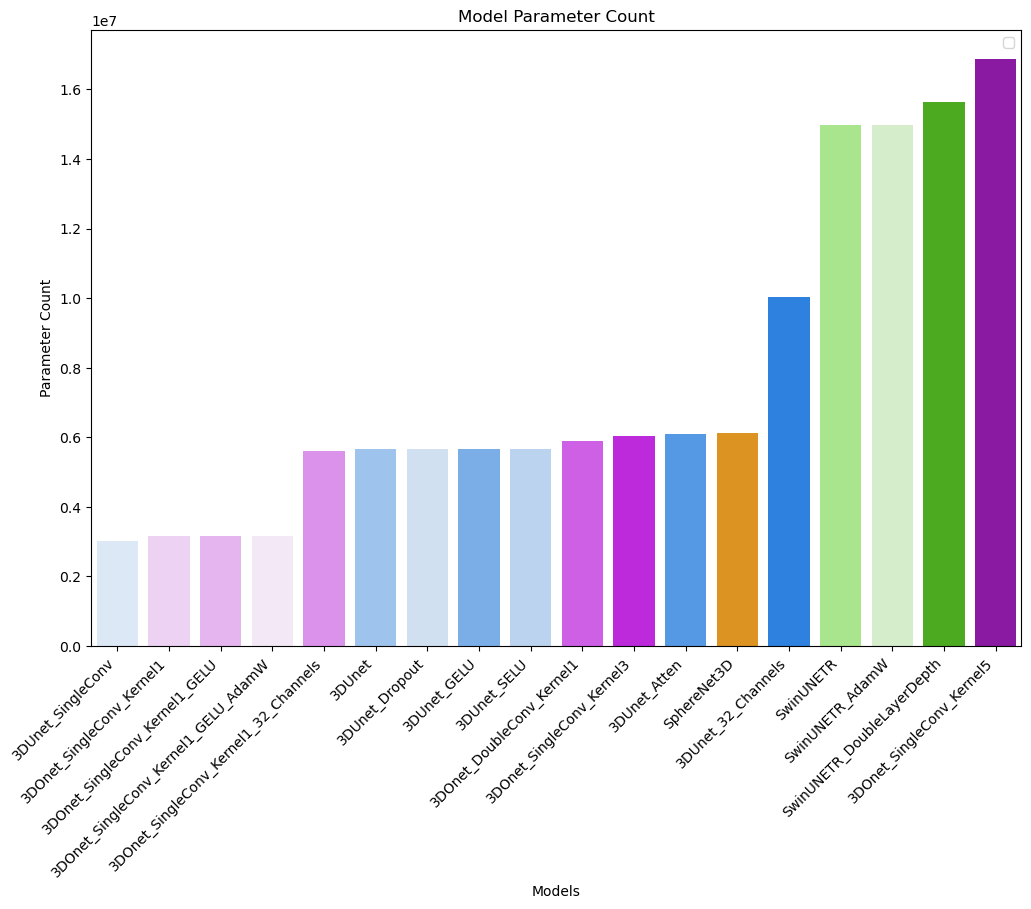

2023-03-26 21:44:09,897 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


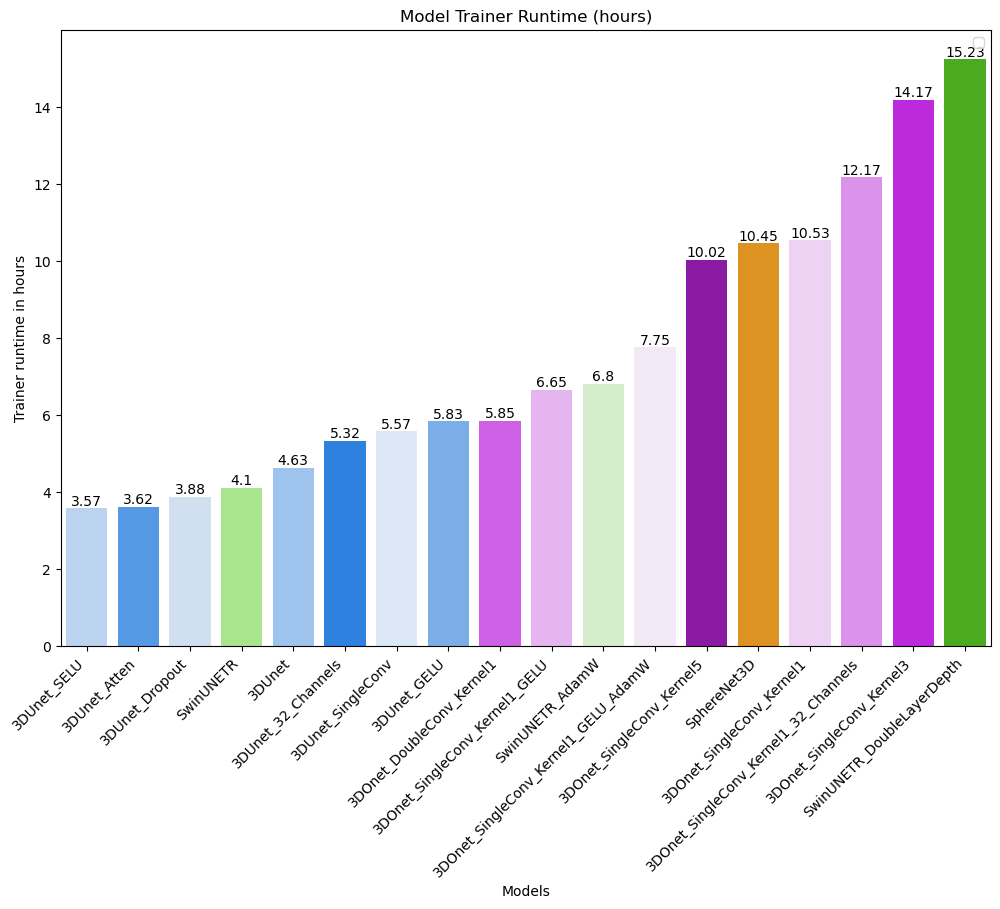

In [45]:
from utils.viz_eval_utils import plot_param_count, plot_train_losses, plot_val_losses, plot_train_dices, plot_val_dices, plot_train_jaccards, plot_val_jacards, plot_trainer_runtime

plot_param_count(results_dict=train_results_dict, paletteCols=cols)
plot_trainer_runtime(results_dict=train_results_dict, paletteCols=cols)


## Plot model train and val losses, dice scores and jaccard scores across 50 training epochs

### Plots are saved in the `results` folder

### 3DONET and 3DSphereNET (ours, purple and orange respectively) tend to show better performance despite having a lower parameter count

### Some 3DONET model with higher parameter count (darker shades of purple) display eratic training curves for earlier epochs

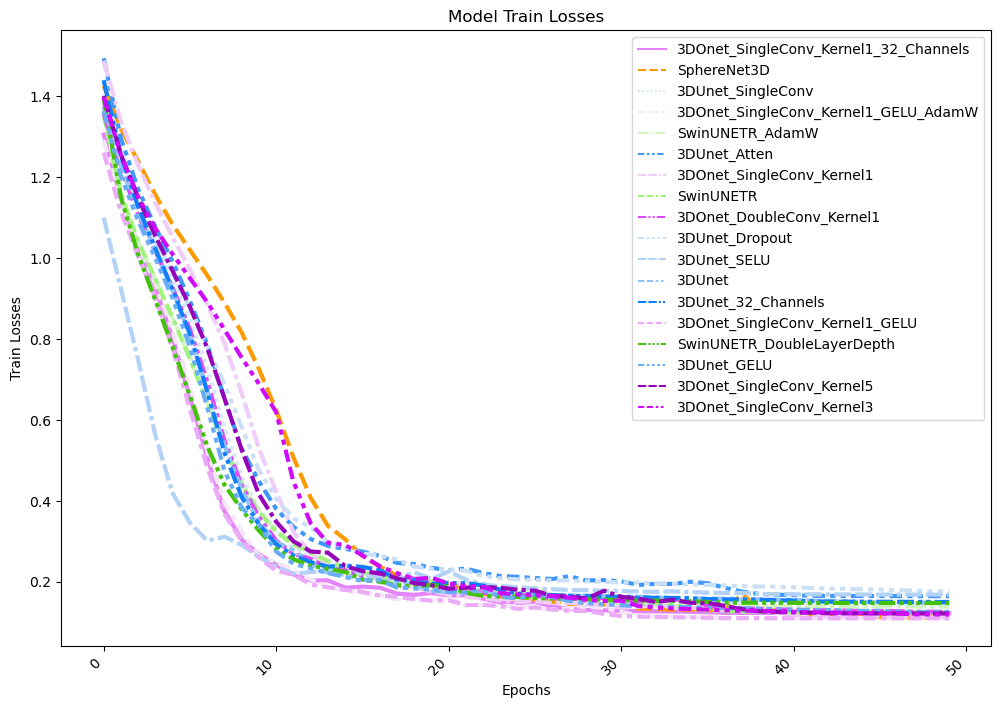

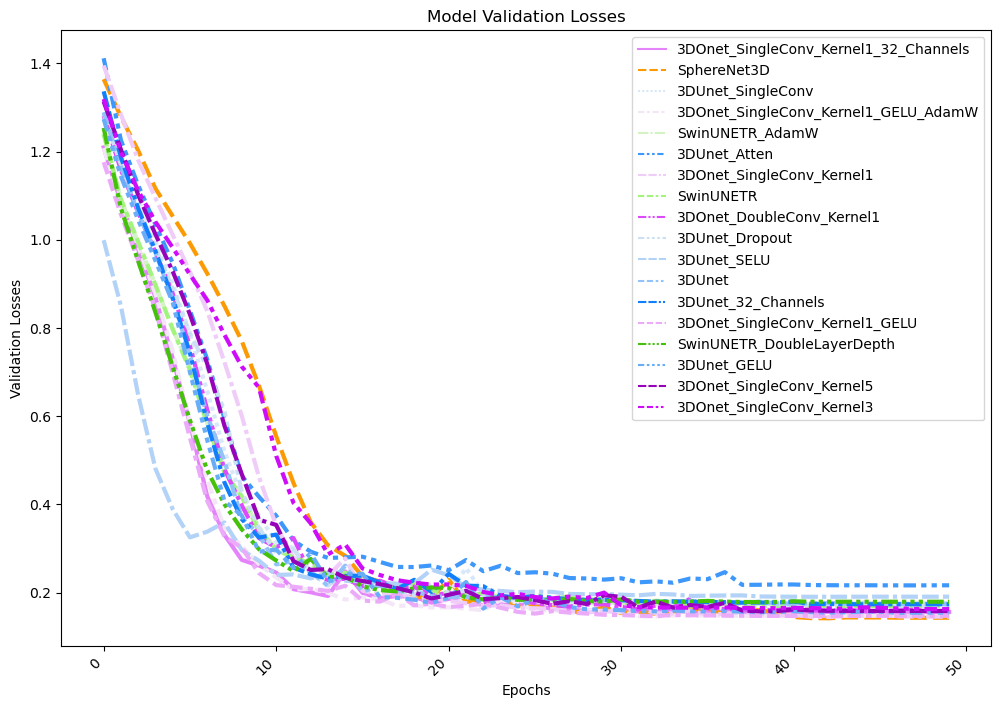

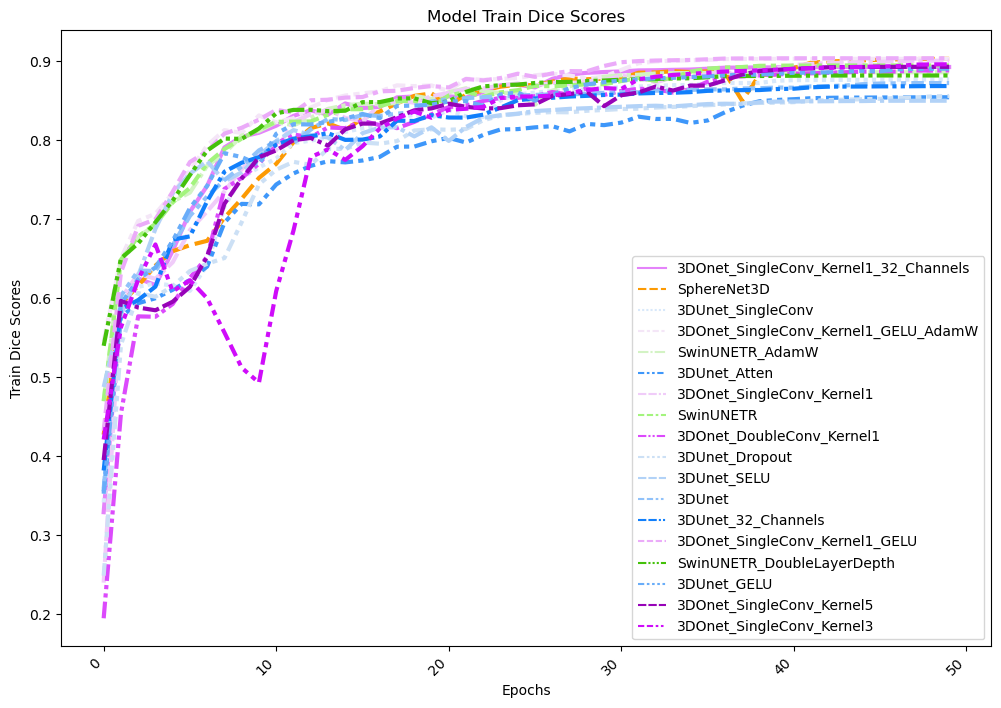

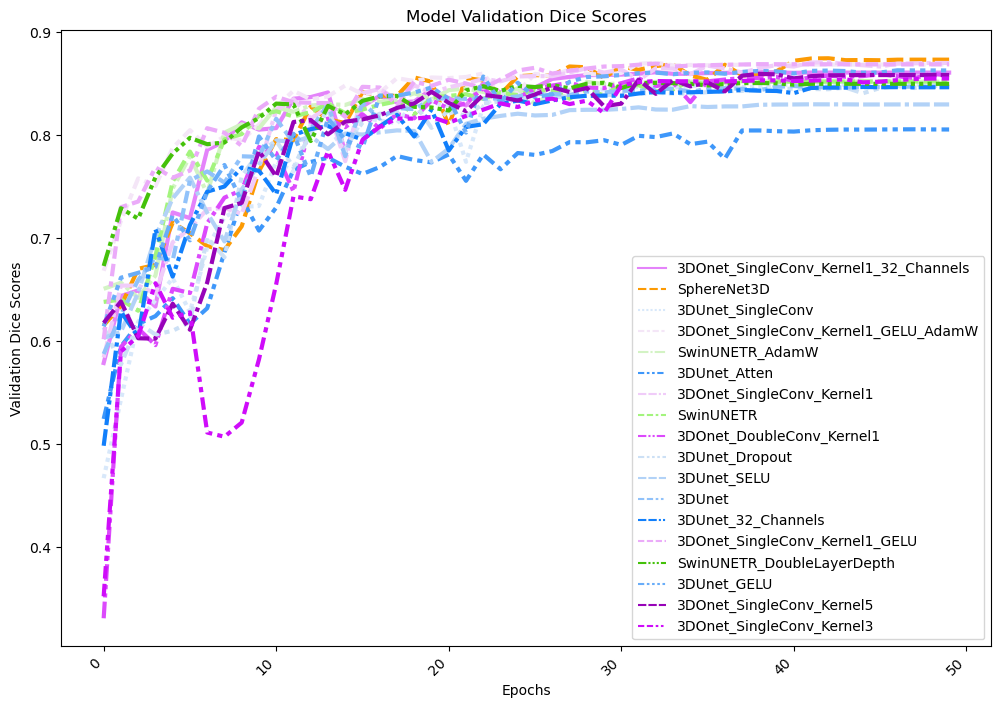

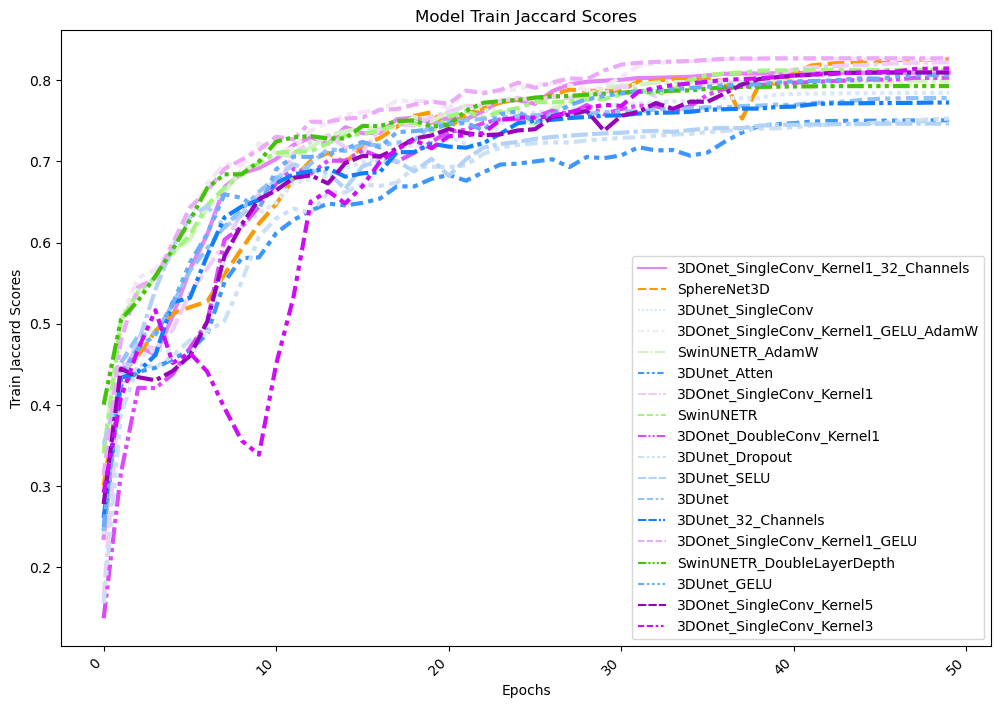

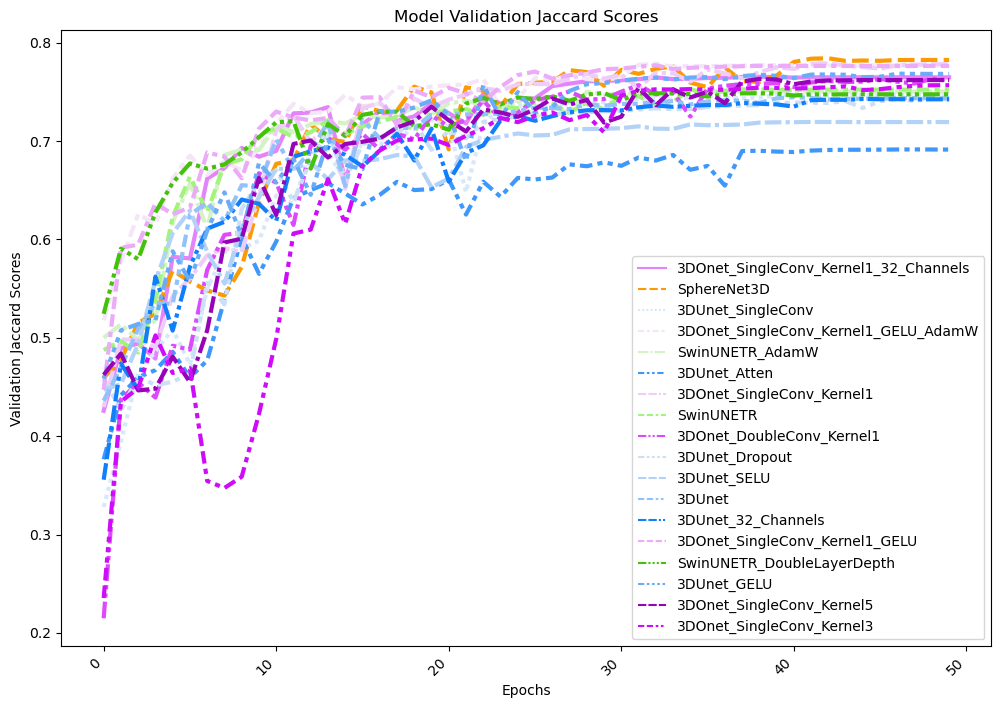

In [46]:

plot_train_losses(results_dict=train_results_dict, paletteCols=cols)
plot_val_losses(results_dict=train_results_dict, paletteCols=cols)
plot_train_dices(results_dict=train_results_dict, paletteCols=cols)
plot_val_dices(results_dict=train_results_dict, paletteCols=cols)
plot_train_jaccards(results_dict=train_results_dict, paletteCols=cols)
plot_val_jacards(results_dict=train_results_dict, paletteCols=cols)



## Plot model scores evaluated on 53 samples in test set, using best checkpoint, as well as the inference time required for all 53 samples.

### Plots are saved in the `results` folder

### 3DONET (ours, purple) tend to be better predictors than other models. However, this comes at the cost of higher inference time.

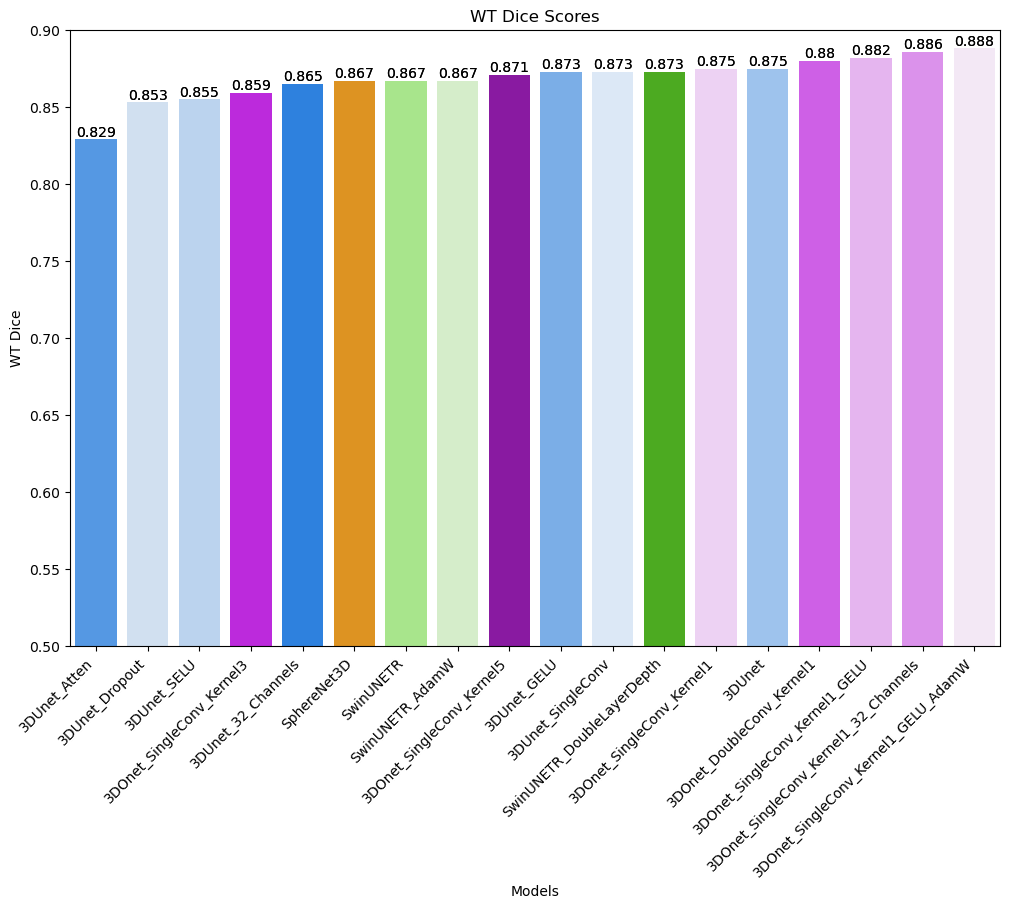

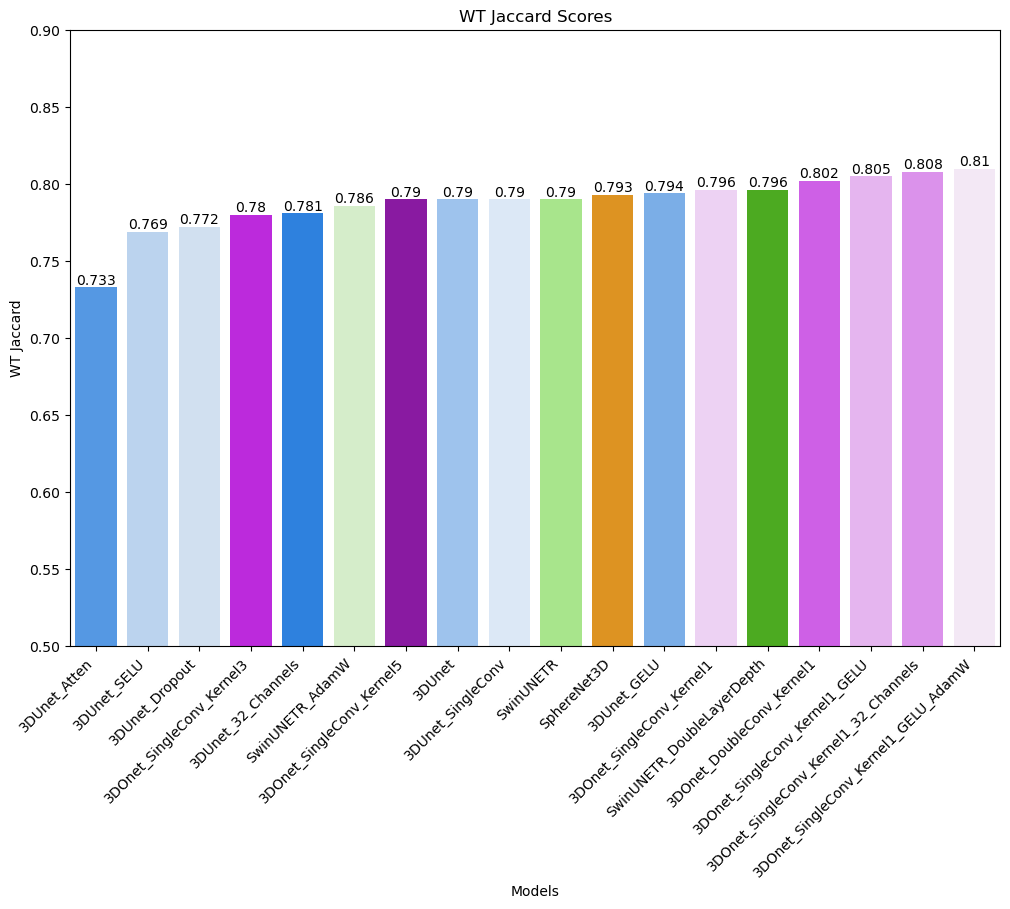

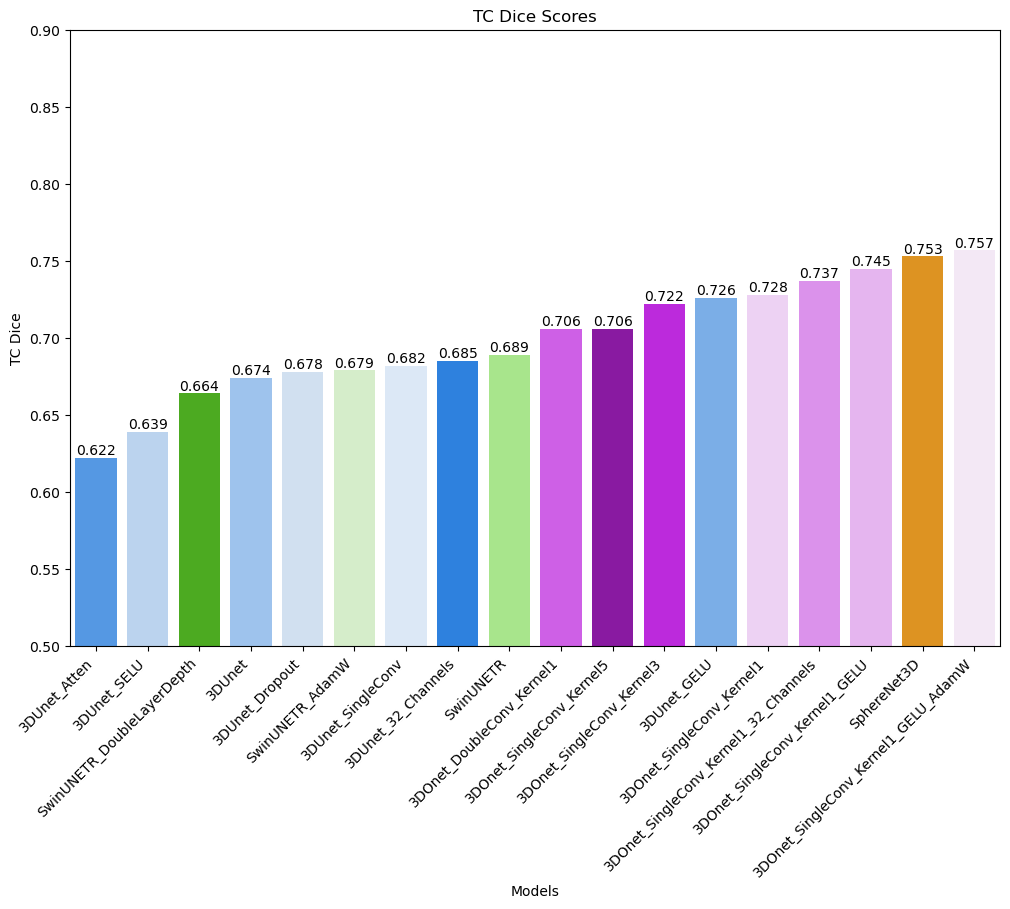

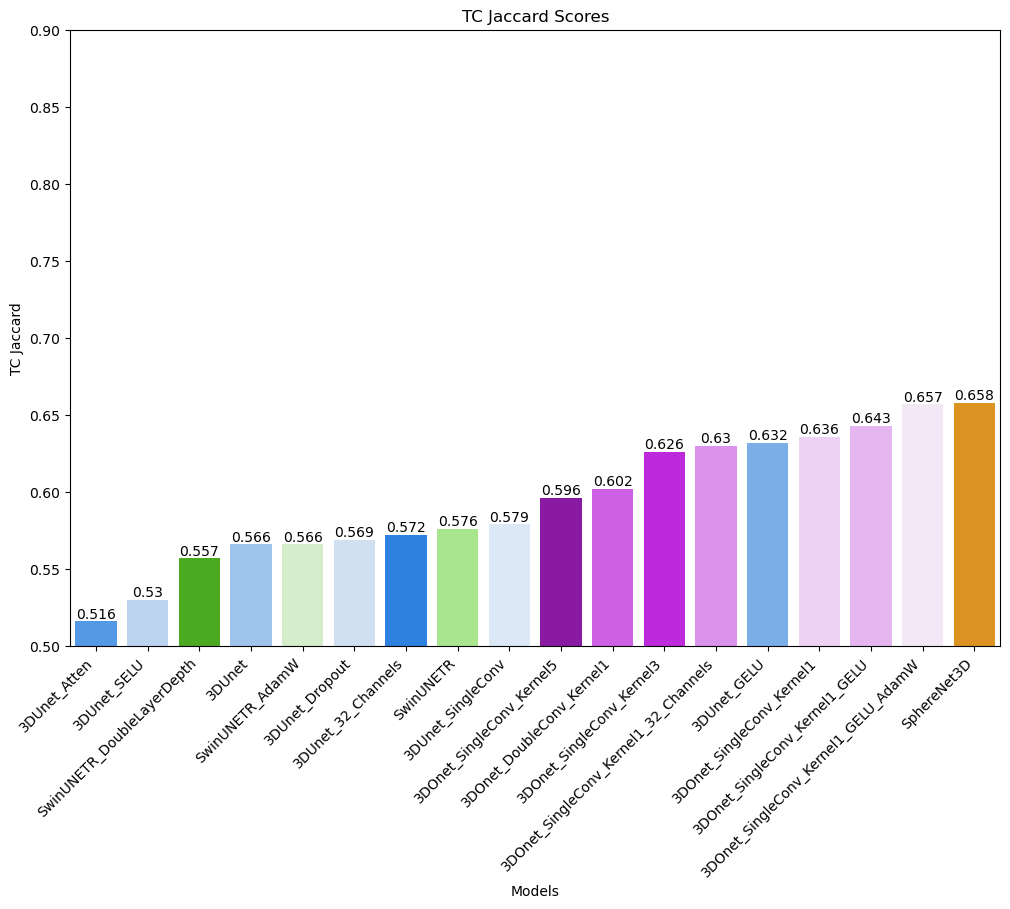

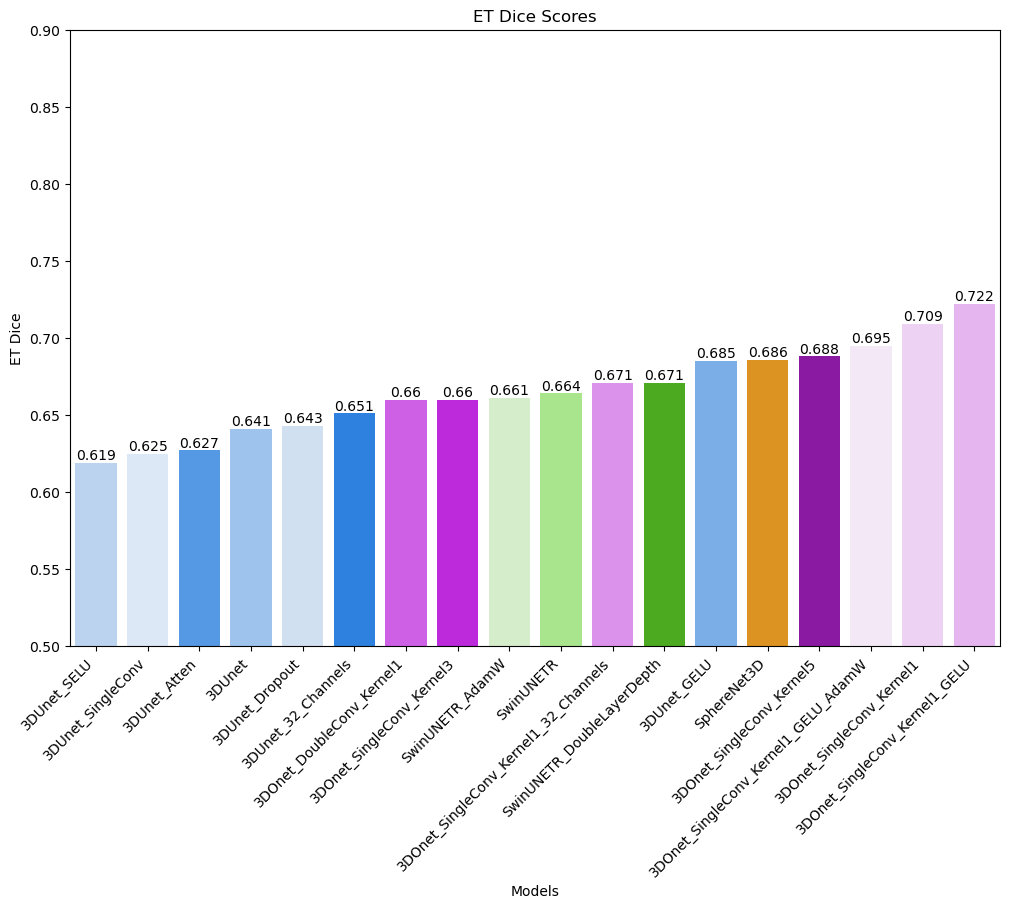

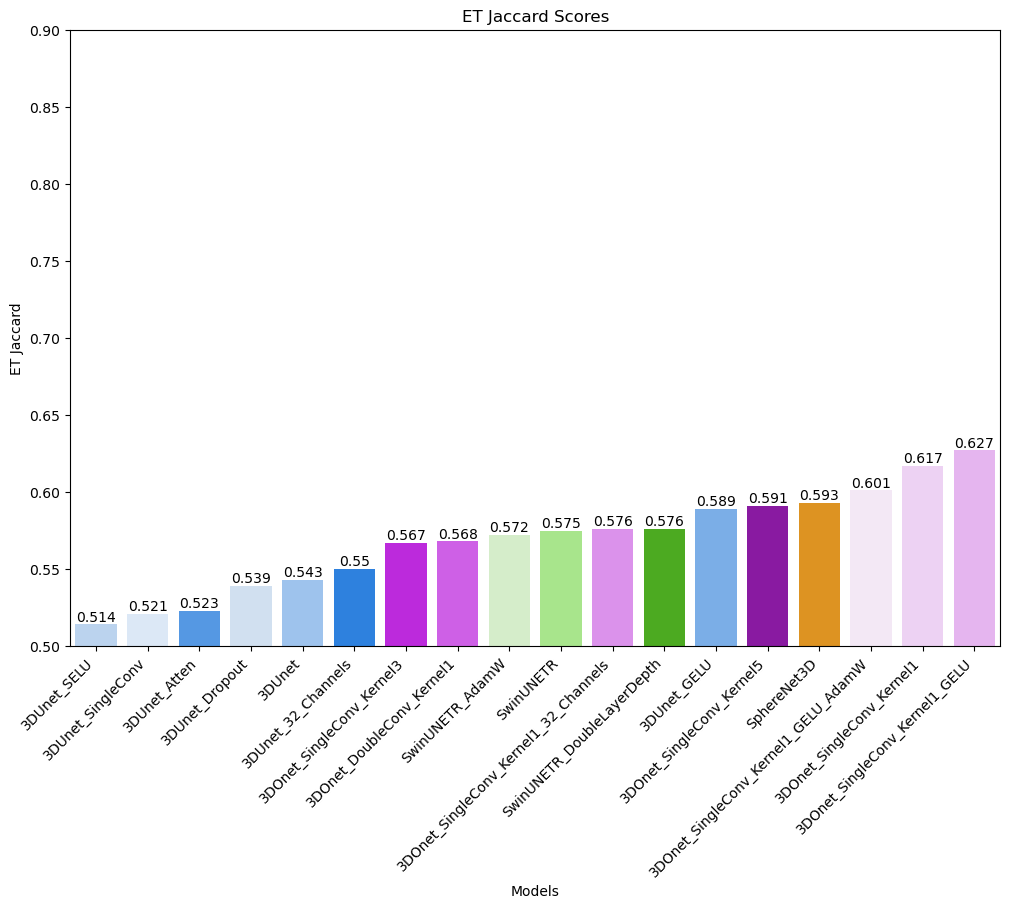

2023-03-26 19:28:03,746 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


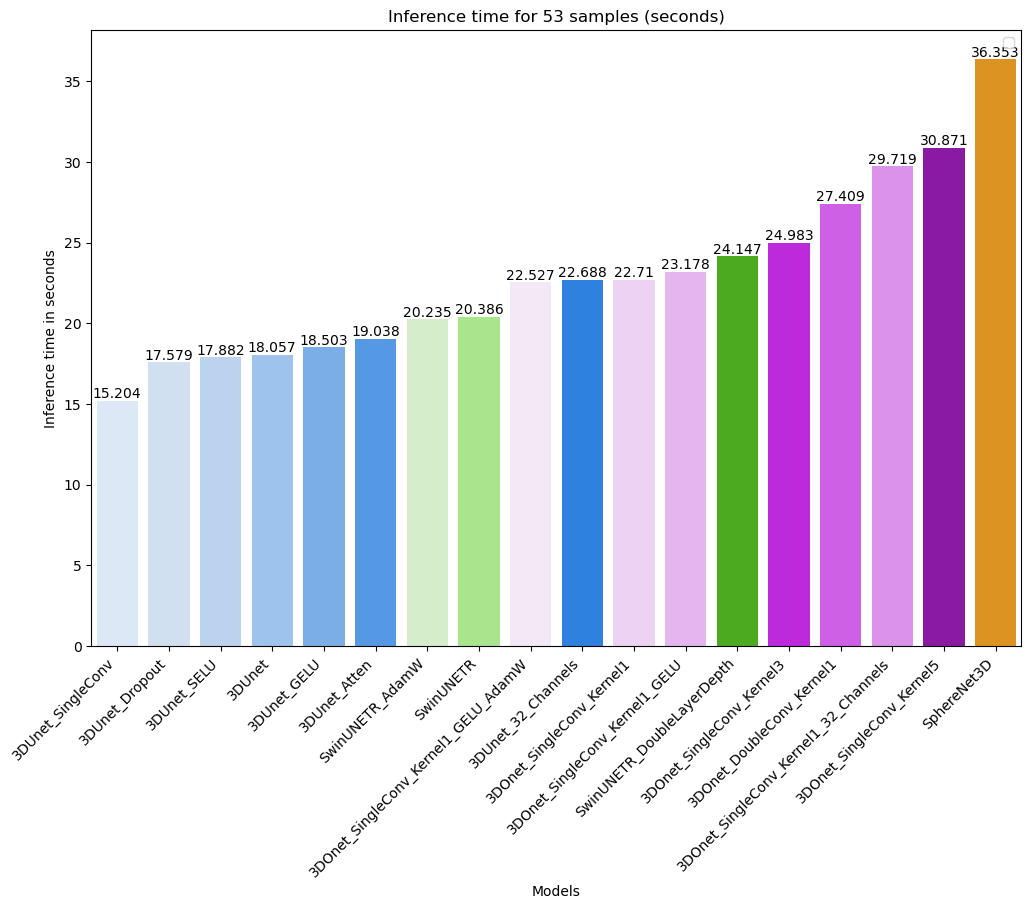

In [20]:
from utils.viz_eval_utils import plot_WT_dice, plot_WT_jaccard, plot_TC_dice, plot_TC_jaccard, plot_ET_dice, plot_ET_jaccard, plot_inference_time


plot_WT_dice(eval_dict_best_epoch, cols)
plot_WT_jaccard(eval_dict_best_epoch, cols)
plot_TC_dice(eval_dict_best_epoch, cols)
plot_TC_jaccard(eval_dict_best_epoch, cols)
plot_ET_dice(eval_dict_best_epoch, cols)
plot_ET_jaccard(eval_dict_best_epoch, cols)
plot_inference_time(eval_dict_best_epoch, cols)
# plot_trainer_runtime(train_results_dict, cols)


### Create dataframe of model parameter count

In [22]:
x = []
y = []
for k in train_results_dict:
  x.append(k)
  y.append(train_results_dict[k]["parameter_count"])
  # parameter_count_df.loc[k] = results_dict[k]["parameter_count"]
data_tuple = list(zip(x, y))
parameter_count_df = pd.DataFrame(
    data_tuple, columns=['Model', 'Params (1e6)']).set_index("Model")
parameter_count_df = parameter_count_df.applymap(lambda x: round(x*1e-6,2))
parameter_count_df


,Params (1e6)
Model,
3DOnet_SingleConv_Kernel1_32_Channels,5.60
SphereNet3D,6.13
3DUnet_SingleConv,3.01
3DOnet_SingleConv_Kernel1_GELU_AdamW,3.15
SwinUNETR_AdamW,14.98
3DUnet_Atten,6.09
3DOnet_SingleConv_Kernel1,3.15
SwinUNETR,14.98
3DOnet_DoubleConv_Kernel1,5.90


### Create dataframe of model train time

In [23]:

x = []
y = []
for k in train_results_dict:
  x.append(k)
  y.append(train_results_dict[k]["trainer_runtime"])
  # parameter_count_df.loc[k] = results_dict[k]["parameter_count"]
y = [round(i.hour+(i.minute/60),3) for i in y]
data_tuple = list(zip(x, y))
trainer_runtime_df = pd.DataFrame(
    data_tuple, columns=['Model', 'Train time (h)']).set_index("Model")
# trainer_runtime_df = trainer_runtime_df.applymap(lambda x: round(x*1e-6, 2))
trainer_runtime_df


,Train time (h)
Model,
3DOnet_SingleConv_Kernel1_32_Channels,12.167
SphereNet3D,10.450
3DUnet_SingleConv,5.567
3DOnet_SingleConv_Kernel1_GELU_AdamW,7.750
SwinUNETR_AdamW,6.800
3DUnet_Atten,3.617
3DOnet_SingleConv_Kernel1,10.533
SwinUNETR,4.100
3DOnet_DoubleConv_Kernel1,5.850


### Combine the above dataframe with dataframe of the evaluation results to create a dataframe with the full results statistics for each model 

In [24]:
results_df = pd.DataFrame()
# for k in eval_dict_best_epoch:
results_df = pd.DataFrame.from_dict(eval_dict_best_epoch)
results_df = results_df.transpose().sort_index()
results_rounded = results_df
results_rounded["Inference time"] = results_rounded["Inference time"].apply(
    lambda x: float(np.format_float_positional(x.seconds + x.microseconds*1e-6, precision=4, unique=False, fractional=False, trim='k')))
# results_df.applymap('{:,.2f}'.format)
# results_rounded
results_rounded = results_rounded.applymap(lambda x: float(
    np.format_float_positional(x, precision=4, unique=False, fractional=False, trim='k')))

results_rounded = results_rounded.join(trainer_runtime_df)
results_rounded = results_rounded.join(parameter_count_df)

results_rounded.rename(
    columns={'Inference time': 'Infer time (s)'}, inplace=True)
results_rounded.to_csv("results/full_results_statistics.csv")
results_rounded


,WT dice,WT jaccard,TC dice,TC jaccard,ET dice,ET jaccard,Infer time (s),Train time (h),Params (1e6)
3DOnet_DoubleConv_Kernel1,0.8801,0.8022,0.7058,0.6017,0.6600,0.5678,27.41,5.850,5.90
3DOnet_SingleConv_Kernel1,0.8753,0.7956,0.7282,0.6363,0.7093,0.6172,22.71,10.533,3.15
3DOnet_SingleConv_Kernel1_32_Channels,0.8860,0.8085,0.7365,0.6300,0.6706,0.5761,29.72,12.167,5.60
3DOnet_SingleConv_Kernel1_GELU,0.8817,0.8050,0.7449,0.6435,0.7218,0.6266,23.18,6.650,3.15
3DOnet_SingleConv_Kernel1_GELU_AdamW,0.8879,0.8097,0.7572,0.6565,0.6948,0.6006,22.53,7.750,3.15
3DOnet_SingleConv_Kernel3,0.8593,0.7797,0.7217,0.6264,0.6597,0.5667,24.98,14.167,6.03
3DOnet_SingleConv_Kernel5,0.8705,0.7897,0.7064,0.5962,0.6877,0.5905,30.87,10.017,16.86
3DUnet,0.8750,0.7900,0.6736,0.5661,0.6414,0.5425,18.06,4.633,5.65
3DUnet_32_Channels,0.8651,0.7810,0.6849,0.5722,0.6508,0.5498,22.69,5.317,10.05
3DUnet_Atten,0.8290,0.7334,0.6216,0.5163,0.6267,0.5231,19.04,3.617,6.09


### Print to latex for transferring into report

In [25]:
print(results_rounded.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  WT dice &  WT jaccard &  TC dice &  TC jaccard &  ET dice &  ET jaccard &  Infer time (s) &  Train time (h) &  Params (1e6) \\
\midrule
3DOnet\_DoubleConv\_Kernel1             &   0.8801 &      0.8022 &   0.7058 &      0.6017 &   0.6600 &      0.5678 &           27.41 &           5.850 &          5.90 \\
3DOnet\_SingleConv\_Kernel1             &   0.8753 &      0.7956 &   0.7282 &      0.6363 &   0.7093 &      0.6172 &           22.71 &          10.533 &          3.15 \\
3DOnet\_SingleConv\_Kernel1\_32\_Channels &   0.8860 &      0.8085 &   0.7365 &      0.6300 &   0.6706 &      0.5761 &           29.72 &          12.167 &          5.60 \\
3DOnet\_SingleConv\_Kernel1\_GELU        &   0.8817 &      0.8050 &   0.7449 &      0.6435 &   0.7218 &      0.6266 &           23.18 &           6.650 &          3.15 \\
3DOnet\_SingleConv\_Kernel1\_GELU\_AdamW  &   0.8879 &      0.8097 &   0.7572 &      0.6565 &   0.6948 &      0.6006 &           22.53 &  

### Plot and compare the predictions of different models for sample 4 (BraTS20_Training_004) against the ground truth at slice 75 across the 3 classes WT, ET, and TC.

Target found:  BraTS20_Training_004
3DOnet_SingleConv_Kernel1_32_Channels loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_32_Channels/your_best_model_20230314-193438.pth. parameters: 5597571
Predicting for:  3DOnet_SingleConv_Kernel1_32_Channels
SphereNet3D loaded with chkpt: Logs/SphereNet3D/your_best_model_20230318-234612.pth. parameters: 6134019
Predicting for:  SphereNet3D
3DUnet_SingleConv loaded with chkpt: Logs/3DUnet_SingleConv/your_best_model_20230322-164448.pth. parameters: 3006507
Predicting for:  3DUnet_SingleConv
3DOnet_SingleConv_Kernel1_GELU_AdamW loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_GELU_AdamW/your_best_model_20230317-181323.pth. parameters: 3150435
Predicting for:  3DOnet_SingleConv_Kernel1_GELU_AdamW
SwinUNETR_AdamW loaded with chkpt: Logs/SwinUNETR_AdamW/your_best_model_20230311-061544.pth. parameters: 14981601
Predicting for:  SwinUNETR_AdamW
3DUnet_Atten loaded with chkpt: Logs/3DUnet_Atten/your_best_model_20230311-221951.pth. parameters: 6094231
Pre

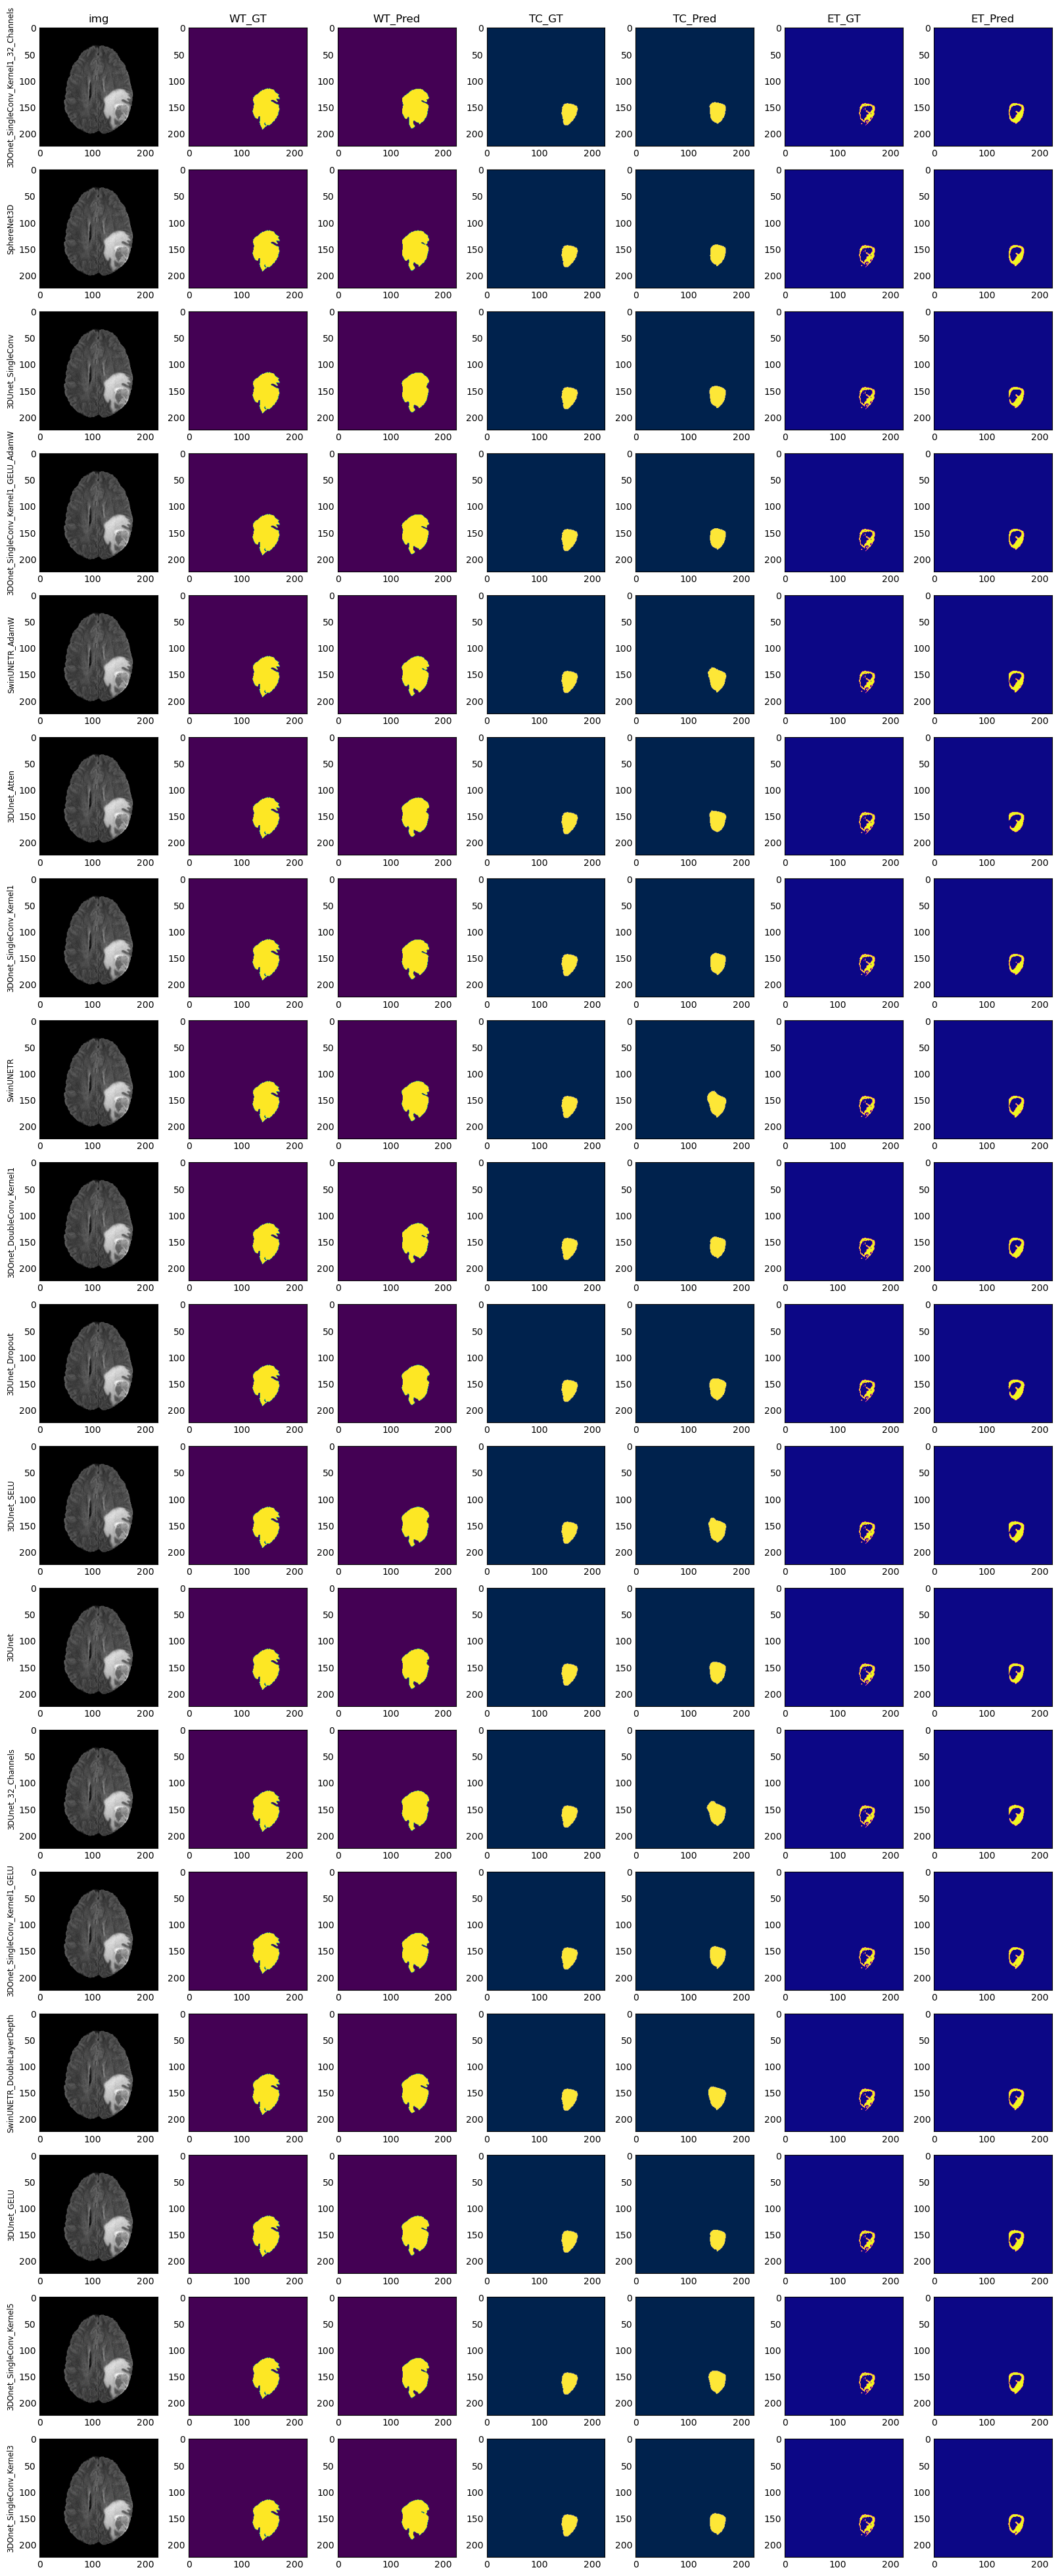

In [35]:
def compare_model_predictions(target="BraTS20_Training_004", treshold=0.5):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  name, imgs, targets = None, None, None
  _, _, test_dataloader = get_dataloaders(
      dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)

  for i, data in enumerate(test_dataloader):
    if data['Id'][0] == target:
      print("Target found: ", target)
      name, imgs, targets = data['Id'][0], data['image'], data['mask']
      
  fig, ax_array = plt.subplots(len(os.listdir("Logs")), 7, figsize=(20, 50))
  
  rows = []
  cols = ['img', 'WT_GT', 'WT_Pred', 'TC_GT', 'TC_Pred', 'ET_GT', 'ET_Pred']
  for i, dirname in enumerate(os.listdir("Logs")):
    
    model_name = dirname
    rows.append(model_name)
    model = modelDict[model_name]
    checkpoint_path = None

    for filename in os.listdir(f"Logs/{dirname}"):
      if "your_best_model" in filename:
        checkpoint_path = f"Logs/{dirname}/{filename}"
        break

    try:
      model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
      model.eval()
      print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    except Exception as e:
      print(
          f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
      print(e)
      break

    with torch.no_grad():
      print("Predicting for: ", model_name)
      imgs, targets = imgs.to(device), targets.to(device)
      logits = model(imgs)
      probs = torch.sigmoid(logits)

      predictions = (probs >= treshold).float()
      predictions = predictions.cpu()
      targets = targets.cpu()

      img, gt, prediction = imgs.cpu(), targets, predictions

      img = img.squeeze()[0].cpu().detach().numpy()
      gt0 = gt[0][0].squeeze().cpu().detach().numpy()
      gt1 = gt[0][1].squeeze().cpu().detach().numpy()
      gt2 = gt[0][2].squeeze().cpu().detach().numpy()
      pred0 = prediction[0][0].squeeze().cpu().detach().numpy()
      pred1 = prediction[0][1].squeeze().cpu().detach().numpy()
      pred2 = prediction[0][2].squeeze().cpu().detach().numpy()

      
      slice_w = 75
      
      ax_array[i][0].imshow(img[slice_w, :, :], cmap="gray")
      ax_array[i][0].tick_params(axis='both', length=0, width=0)
      ax_array[i][0].set_xlabel('')
      ax_array[i][0].set_ylabel('')
      ax_array[i][1].imshow(gt0[slice_w, :, :], cmap="viridis")
      ax_array[i][1].tick_params(axis='both', length=0, width=0)
      ax_array[i][1].set_xlabel('')
      ax_array[i][1].set_ylabel('')
      ax_array[i][2].imshow(pred0[slice_w, :, :], cmap="viridis")
      ax_array[i][2].tick_params(axis='both', length=0, width=0)
      ax_array[i][2].set_xlabel('')
      ax_array[i][2].set_ylabel('')
      ax_array[i][3].imshow(gt1[slice_w, :, :], cmap="cividis")
      ax_array[i][3].tick_params(axis='both', length=0, width=0)
      ax_array[i][3].set_xlabel('')
      ax_array[i][3].set_ylabel('')
      ax_array[i][4].imshow(pred1[slice_w, :, :], cmap="cividis")
      ax_array[i][4].tick_params(axis='both', length=0, width=0)
      ax_array[i][4].set_xlabel('')
      ax_array[i][4].set_ylabel('')
      ax_array[i][5].imshow(gt2[slice_w, :, :], cmap="plasma")
      ax_array[i][5].tick_params(axis='both', length=0, width=0)
      ax_array[i][5].set_xlabel('')
      ax_array[i][5].set_ylabel('')
      ax_array[i][6].imshow(pred2[slice_w, :, :], cmap="plasma")
      ax_array[i][6].tick_params(axis='both', length=0, width=0)
      ax_array[i][6].set_xlabel('')
      ax_array[i][6].set_ylabel('')

    del model
  for ax, col in zip(ax_array[0], cols):
    ax.set_title(col)
  for ax, row in zip(ax_array[:, 0], rows):
    ax.set_ylabel(row, rotation=90, size='small')
  fig.savefig(f"results/prediction_comparison.png",
              format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
  print(
      f"Saving to results/prediction_comparison.png")
  plt.show()
  # fig.suptitle(f'Model: {model_name} | Sample: {name} | Slice: {slice_w}', y=0.7, fontsize=16)


compare_model_predictions()


## Save the predictions and ground truth of different models for sample 4 (BraTS20_Training_004) across slice 50 to 90 with an interval of 5 (slice 50, 55, 60, ..., 90).

### Plots are saved in the models' respective `Logs` directory under the `prediction_samples` folder. 

### Plotting is disabled for this cell due to the large number of plots generated.

In [36]:
def save_predictions_to_logs(target="BraTS20_Training_004", treshold=0.5):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  name, imgs, targets = None, None, None
  _, _, test_dataloader = get_dataloaders(
      dataset=BratsDataset, path_to_csv="./fold_data.csv", val_fold=0, test_fold=1, batch_size=1, do_resizing=True)
  
  for i, data in enumerate(test_dataloader):
    if data['Id'][0] == target:
      print("Target found: ", target)
      name, imgs, targets = data['Id'][0], data['image'], data['mask']
  
  for dirname in os.listdir("Logs"):
    model_name = dirname
    model = modelDict[model_name]
    savepath = f"Logs/{dirname}/prediction_samples"
    if not os.path.isdir(savepath):
      os.mkdir(savepath)
    results = {"Id": [], "image": [], "GT": [], "Prediction": []}

    checkpoint_path = None

    for filename in os.listdir(f"Logs/{dirname}"):
      if "your_best_model" in filename:
        checkpoint_path = f"Logs/{dirname}/{filename}"
        break

    try:
      model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
      model.eval()
      print(f"{model_name} loaded with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
    except Exception as e:
      print(f"Error loading {model_name} with chkpt: {checkpoint_path}. parameters: {count_parameters(model)}")
      print(e)
      break

    with torch.no_grad():
      print("Predicting for: ", model_name)
      imgs, targets = imgs.to(device), targets.to(device)
      logits = model(imgs)
      probs = torch.sigmoid(logits)

      predictions = (probs >= treshold).float()
      predictions = predictions.cpu()
      targets = targets.cpu()
      
      img, gt, prediction = imgs.cpu(), targets, predictions
      
      img = img.squeeze()[0].cpu().detach().numpy()
      gt0 = gt[0][0].squeeze().cpu().detach().numpy()
      gt1 = gt[0][1].squeeze().cpu().detach().numpy()
      gt2 = gt[0][2].squeeze().cpu().detach().numpy()
      pred0 = prediction[0][0].squeeze().cpu().detach().numpy()
      pred1 = prediction[0][1].squeeze().cpu().detach().numpy()
      pred2 = prediction[0][2].squeeze().cpu().detach().numpy()
      
      for i in range(50, 90+1, 5):

        fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(
            1, 7, figsize=(30, 10))
        slice_w = i
        
        ax1.imshow(img[slice_w, :, :], cmap="gray")
        ax1.set_title(f'img')
        ax2.imshow(gt0[slice_w, :, :], cmap="viridis")
        ax2.set_title(f'WT_GT')
        ax3.imshow(pred0[slice_w, :, :], cmap="viridis")
        ax3.set_title(f'WT_Pred')
        ax4.imshow(gt1[slice_w, :, :], cmap="cividis")
        ax4.set_title(f'TC_GT')
        ax5.imshow(pred1[slice_w, :, :], cmap="cividis")
        ax5.set_title(f'TC_Pred')
        ax6.imshow(gt2[slice_w, :, :], cmap="plasma")
        ax6.set_title(f'ET_GT')
        ax7.imshow(pred2[slice_w, :, :], cmap="plasma")
        ax7.set_title(f'ET_Pred')
        # fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.suptitle(
            f'Model: {model_name} | Sample: {name} | Slice: {i}', y=0.7, fontsize=16)
        # plt.show()
        fig.savefig(f"{savepath}/prediction_{name}_slice_{i}.png",
                    format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
        print(
            f"Saving to {savepath}/prediction_{name}_slice_{i}.png")
        plt.close(fig)
    del model
  

save_predictions_to_logs()

Target found:  BraTS20_Training_004
3DOnet_SingleConv_Kernel1_32_Channels loaded with chkpt: Logs/3DOnet_SingleConv_Kernel1_32_Channels/your_best_model_20230314-193438.pth. parameters: 5597571
Predicting for:  3DOnet_SingleConv_Kernel1_32_Channels
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channels/prediction_samples/prediction_BraTS20_Training_004_slice_50.png
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channels/prediction_samples/prediction_BraTS20_Training_004_slice_55.png
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channels/prediction_samples/prediction_BraTS20_Training_004_slice_60.png
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channels/prediction_samples/prediction_BraTS20_Training_004_slice_65.png
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channels/prediction_samples/prediction_BraTS20_Training_004_slice_70.png
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channels/prediction_samples/prediction_BraTS20_Training_004_slice_75.png
Saving to Logs/3DOnet_SingleConv_Kernel1_32_Channe